## Pytorch Implementation of "ArtCoder: An End-to-end Method for Generating Scanning-robust Stylized QR Codes"

### Import dependencies

In [ ]:
from collections import namedtuple

import torch
from torchvision import models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla K80'

### Define VGG model

In [ ]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()

        vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

### Define helper functions

In [ ]:
from PIL import Image
import os
import numpy as np
import math
import pandas as pd
from torchvision import transforms
import shutil

In [ ]:
unloader = transforms.ToPILImage()
load = transforms.ToTensor()

In [ ]:
def load_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size), Image.ANTIALIAS)
    return img

In [ ]:
def add_pattern(target_PIL, code_PIL, module_number=37, module_size=16):
    target_img = np.asarray(target_PIL)
    code_PIL = code_PIL.convert('RGB')
    code_img = np.array(code_PIL)
    if code_img.shape[2] == 4:
      code_img = code_img[:, :, :3]
    output = target_img
    output = np.require(output, dtype='uint8', requirements=['O', 'W'])

    print(f'Output shape: {output.shape}, Target shape: {target_img.shape}, Code shape: {code_img.shape}')

    ms = module_size  # module size
    mn = module_number  # module_number

    output[0 * ms:(8 * ms) - 1, 0 * ms:(8 * ms) - 1, :] = code_img[0 * ms:(8 * ms) - 1, 0 * ms:(8 * ms) - 1, :]
    
    output[((mn - 8) * ms) + 1:(mn * ms), 0 * ms:(8 * ms) - 1, :] = code_img[((mn - 8) * ms) + 1:(mn * ms), 0 * ms:(8 * ms) - 1, :]
    
    output[0 * ms: (8 * ms) - 1, ((mn - 8) * ms) + 1:(mn * ms), :] = code_img[0 * ms: (8 * ms) - 1, ((mn - 8) * ms) + 1:(mn * ms), :]
    
    output[28 * ms: (33 * ms) - 1, 28 * ms:(33 * ms) - 1, :] = code_img[28 * ms: (33 * ms) - 1, 28 * ms:(33 * ms) - 1, :]

    output = Image.fromarray(output.astype('uint8'))
    print('Added finder and alignment patterns.')
    return output

In [ ]:
def del_file(filepath):
    del_list = os.listdir(filepath)
    for f in del_list:
        file_path = os.path.join(filepath, f)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [ ]:
def get_binary_result(img_code, module_size, module_number=37):
    binary_result = np.zeros((module_number, module_number))
    for j in range(module_number):
        for i in range(module_number):
            module = img_code[i * module_size:(i + 1) * module_size, j * module_size:(j + 1) * module_size]
            module_color = np.around(np.mean(module), decimals=2)
            if module_color < 128:
                binary_result[i, j] = 0
            else:
                binary_result[i, j] = 1
    return binary_result

In [ ]:
def get_center_pixel(img_target, module_size):
    center_mat = np.zeros((37, 37))
    for j in range(37):
        for i in range(37):
            module = img_target[i * module_size:(i + 1) * module_size, j * module_size:(j + 1) * module_size]
            module_color = np.mean(module[5:12, 5:12])
            center_mat[i, j] = module_color
    return center_mat

In [ ]:
def get_error_module(center_mat, code_result, threshold_b, threshold_w):
    error_module = np.ones((37, 37))
    for j in range(37):
        for i in range(37):
            center_pixel = center_mat[i, j]
            right_result = code_result[i, j]
            if right_result == 0 and center_pixel < threshold_b:
                error_module[i, j] = 0
            elif right_result == 1 and center_pixel > threshold_w:
                error_module[i, j] = 0
            else:
                error_module[i, j] = 1
    return error_module

In [ ]:
def get_action_matrix(img_target, img_code, module_size=16, IMG_SIZE=592, Dis_b=50, Dis_w=200):
    img_code = np.require(np.asarray(img_code.convert('L')), dtype='uint8', requirements=['O', 'W'])
    img_target = np.require(np.array(img_target.convert('L')), dtype='uint8', requirements=['O', 'W'])

    ideal_result = get_binary_result(img_code, module_size)
    center_mat = get_center_pixel(img_target, module_size)
    error_module = get_error_module(center_mat, code_result=ideal_result,
                                    threshold_b=Dis_b,
                                    threshold_w=Dis_w)
    return error_module, ideal_result

In [ ]:
def get_target(binary_result, b_robust, w_robust, module_num=37, module_size=16):
    img_size = module_size * module_num
    target = np.require(np.ones((img_size, img_size)), dtype='uint8', requirements=['O', 'W'])

    for i in range(module_num):
        for j in range(module_num):
            one_binary_result = binary_result[i, j]
            if one_binary_result == 0:
                target[i * module_size:(i + 1) * module_size, j * module_size:(j + 1) * module_size] = b_robust
            else:
                target[i * module_size:(i + 1) * module_size, j * module_size:(j + 1) * module_size] = w_robust

    target = load(Image.fromarray(target.astype('uint8')).convert('RGB')).unsqueeze(0).cuda()
    return target

In [ ]:
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

In [ ]:
def save_image_epoch(tensor, path, name, code_pil, addpattern=True):
    image = tensor_to_PIL(tensor)
    if addpattern == True:
        image = add_pattern(image, code_pil, module_number=37, module_size=16)
    image.save(os.path.join(path, "epoch_" + str(name)))

In [ ]:
def get_3DGauss(s=0, e=15, sigma=1.5, mu=7.5):
    x, y = np.mgrid[s:e:16j, s:e:16j]
    z = (1 / (2 * math.pi * sigma ** 2)) * np.exp(-((x - mu) ** 2 + (y - mu) ** 2) / (2 * sigma ** 2))
    z = torch.from_numpy(MaxMinNormalization(z.astype(np.float32)))
    for j in range(16):
        for i in range(16):
            if z[i, j] < 0.1:
                z[i, j] = 0
    return z

In [ ]:
def MaxMinNormalization(loss_img):
    maxvalue = np.max(loss_img)
    minvalue = np.min(loss_img)
    img = (loss_img - minvalue) / (maxvalue - minvalue)
    img = np.around(img, decimals=2)
    return img

### Define SS Layer

In [ ]:
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt


class SSlayer(nn.Module):
    '''Sampling Simulation Layer'''
    def __init__(self, requires_grad=False):
        super(SSlayer, self).__init__()

        cov_module = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=16, stride=16, padding=0, bias=False)

        weight = get_3DGauss()  # [16,16]
        weight = weight.unsqueeze(0).unsqueeze(0)  # [1,1,16,16]
        weight = torch.cat([weight, weight, weight], dim=1)  # [1,3,16,16]
        cov_module.weight = nn.Parameter(weight)
        self.conv_module = nn.Sequential(
            cov_module
        )

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = x.repeat(1, 1, 1, 1)
        x = self.conv_module(x)
        return x

### Putting it all together

In [ ]:
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch

In [ ]:
STYLE_IMG_PATH = '.img/style1.jpg'
CONTENT_IMG_PATH = '.img/taj_content.jpg'
CODE_PATH = '.img/taj_code.png'
OUTPUT_DIR = './output/'

LEARNING_RATE = 0.001

STYLE_WEIGHT = 1e15
CONTENT_WEIGHT = 1e7
CODE_WEIGHT = 1e20

MODULE_SIZE = 16
MODULE_NUM = 37

EPOCHS = 50000

Dis_b = 80
Dis_w = 180
# Dis_b = 51
# Dis_w = 203

Correct_b = 50
Correct_w = 200
USE_ACTIVATION_MECHANISM = True
del_file(OUTPUT_DIR)
IMAGE_SIZE = MODULE_SIZE * MODULE_NUM

In [ ]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

In [ ]:
vgg = Vgg19(requires_grad=False).cuda()  # vgg19 model
ss_layer = SSlayer(requires_grad=False).cuda() # SS Layer

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
print(vgg)

Vgg19(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (sli

In [ ]:
style_img = load_image(filename=STYLE_IMG_PATH, size=IMAGE_SIZE)
content_img = load_image(filename=CONTENT_IMG_PATH, size=IMAGE_SIZE)
code_img = load_image(filename=CODE_PATH, size=IMAGE_SIZE)
init_img = add_pattern(content_img, code_img)

style_img = transform(style_img)
content_img = transform(content_img)
init_img = transform(init_img)

init_img = init_img.repeat(1, 1, 1, 1).cuda()
style_img = style_img.repeat(1, 1, 1, 1).cuda()  # make fake batch
content_img = content_img.repeat(1, 1, 1, 1).cuda()

Output shape: (592, 592, 3), Target shape: (592, 592, 3), Code shape: (592, 592, 3)
Added finder and alignment patterns.


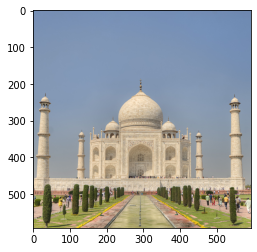

In [ ]:
plt.imshow(tensor_to_PIL(content_img))

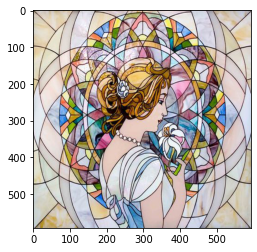

In [ ]:
plt.imshow(tensor_to_PIL(style_img))

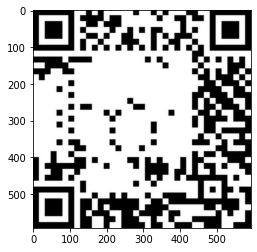

In [ ]:
plt.imshow(code_img)

torch.Size([1, 256, 148, 148])


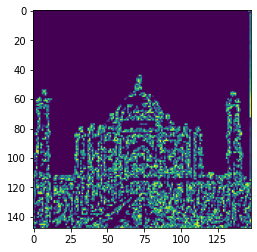

In [ ]:
features_style = vgg(style_img)  # feature maps extracted from VGG
features_content = vgg(content_img)

print(features_content.relu3_3.shape)
temp = tensor_to_PIL(features_content.relu3_3.squeeze()[5])
plt.imshow(temp)
plt.show()

In [ ]:
gram_style = [gram_matrix(i) for i in features_style]  # gram matrix of style feature
mse_loss = nn.MSELoss()

In [ ]:
y = init_img.detach()  # y is the target output. Optimized start from the content image.
y = y.requires_grad_()  # let y to require grad

optimizer = optim.Adam([y], lr=LEARNING_RATE)  # let optimizer to optimize the tensor y

torch.Size([1, 1, 37, 37])


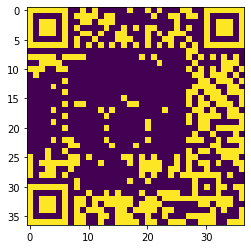

In [ ]:
error_matrix, ideal_result = get_action_matrix(
    img_target=tensor_to_PIL(y),
    img_code=code_img,
    Dis_b=Dis_b, Dis_w=Dis_w
)
code_target = ss_layer(get_target(ideal_result, b_robust=Correct_b, w_robust=Correct_w))

print(code_target.shape)
temp = tensor_to_PIL(code_target.squeeze())
plt.imshow(temp)
plt.show()

In [ ]:
print(" Start training =============================================")
for epoch in range(EPOCHS):

    def closure(code_target=code_target):

        optimizer.zero_grad()
        y.data.clamp_(0, 1)
        features_y = vgg(y)  # feature maps of y extracted from VGG
        gram_style_y = [gram_matrix(i) for i in
                        features_y]  # gram matrices of feature_y in relu1_2,2_2,3_3,4_3

        fc = features_content.relu3_3  # content target in relu3_3
        fy = features_y.relu3_3  # y in relu4_3

        content_loss = CONTENT_WEIGHT * mse_loss(fc, fy)  # content loss

        style_loss = 0  # add style_losses in relu1_2,2_2,3_3,4_3
        for i in [0, 1, 2, 3]:
            style_loss += mse_loss(gram_style_y[i], gram_style[i])
        style_loss = STYLE_WEIGHT * style_loss

        code_y = ss_layer(y)

        if USE_ACTIVATION_MECHANISM == 1:
            error_matrix, ideal_result = get_action_matrix(
                img_target=tensor_to_PIL(y),
                img_code=code_img,
                Dis_b=Dis_b, Dis_w=Dis_w)
            activate_num = np.sum(error_matrix)
            activate_weight = torch.tensor(error_matrix.astype('float32'))
            code_y = code_y.cpu() * activate_weight
            code_target = code_target.cpu() * activate_weight
        else:
            code_y = code_y.cpu()
            code_target = code_target.cpu()
            activate_num = MODULE_NUM * MODULE_NUM

        code_loss = CODE_WEIGHT * mse_loss(code_target.cuda(), code_y.cuda())

        total_loss = style_loss + code_loss + content_loss # Total loss
        total_loss.backward(retain_graph=True)

        if epoch % 20 == 0:
            print(
                "Epoch {}: Style Loss : {:4f}. Content Loss: {:4f}. Code Loss: {:4f}. Activated module number: {:4.2f}. Discriminate_b：{:4.2f}. Discriminate_w：{:4.2f}.".format(
                    epoch, style_loss, content_loss, code_loss, activate_num, Dis_b, Dis_w)
            )
        if epoch % 200 == 0:
            img_name = 'epoch=' + str(epoch) + '__Wstyle=' + str("%.1e" % STYLE_WEIGHT) + '__Wcode=' + str(
                "%.1e" % CODE_WEIGHT) + '__Wcontent' + str(
                "%.1e" % CONTENT_WEIGHT) + '.jpg'
            save_image_epoch(y, OUTPUT_DIR, img_name, code_img, addpattern=True)
            print('Save output: ' + img_name)
            return total_loss

    optimizer.step(closure)

 Start training =============================================
Epoch 0: Style Loss : 77143834624.000000. Content Loss: 12884284.000000. Code Loss: 12264749692610060222464.000000. Activated module number: 1024.00. Discriminate_b：80.00. Discriminate_w：180.00.
Output shape: (592, 592, 3), Target shape: (592, 592, 3), Code shape: (592, 592, 3)
Added finder and alignment patterns.
Save output: epoch=0__Wstyle=1.0e+15__Wcode=1.0e+20__Wcontent1.0e+07.jpg
Epoch 20: Style Loss : 50307702784.000000. Content Loss: 26266672.000000. Code Loss: 10828438055551017943040.000000. Activated module number: 1014.00. Discriminate_b：80.00. Discriminate_w：180.00.
Epoch 40: Style Loss : 31999213568.000000. Content Loss: 38781452.000000. Code Loss: 9530384675252436205568.000000. Activated module number: 1006.00. Discriminate_b：80.00. Discriminate_w：180.00.
Epoch 60: Style Loss : 21981657088.000000. Content Loss: 47732844.000000. Code Loss: 8362740340513761656832.000000. Activated module number: 986.00. Discrimin

KeyboardInterrupt: ignored